# Stepshifter using Darts

## Introduction 

### 1. Stepshifter

The stepshifter model is trained on data that is shifted relative to the dependent variable. 

The step size determines how far into the future the resulting model will be able to predict.

For instance, with a step size of 1, the independent variables are offset by one time step compared to the dependent variable. See below:

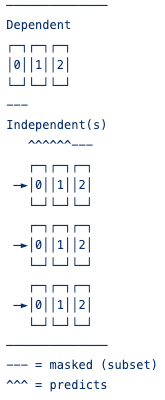

### 2. Training and predicting procedures

Suppose we have data ranging from $ \tau_0 $ to $ \tau_f $, where $ \tau_0 $ is the first observation available for training, and $ \tau_f $ is the last observation. We create three partitions: 
1. Calibration partition from $ \tau_0 $ to $ \tau_c $, 

2. Testing partition from $ \tau_0 $ to $ \tau_t $,  

3. Forecasting partition from $ \tau_0 $ to $ \tau_f $,
 
where $\tau_c < \tau_t < \tau_f$.

For calibration and testing partition, the period is further divided into two parts: train and predict. 

For forecasting partition, true forecasts are generated with number of months into the future. We refer these as steps **_s_** $ \in [1, 36]$.

| **Partition**       | **Train**             | **Predict**               |
|---------------------|-----------------------|---------------------------|
| **Calibration**     | $ [\tau_0, \tau_c'] $ | $ [\tau_c' + 1, \tau_c] $ |
| **Testing**         | $ [\tau_0, \tau_t'] $ | $ [\tau_t' + 1, \tau_t] $ |
| **Forecasting**     | $ [\tau_0, \tau_f] $  | $ [\tau_f + 1, \tau_f + 1 + s_{max}] $   |


For each step $s \in [1, 36]$, we do the following prodedure:
1. Train the model on the calibration train period. 

2. Generate predictions for the calibration predict period and evaluate the model. 

3. Repeat step 1 and 2 by tuning hyperparameters.

4. Train the model on the testing train period with parameters from previous step. 

5. Generate predictions for the testing predict period and evaluate the model again.

6. Train the model on the forecasting train period, i.e., the whole observation period. 

7. Generate true diagonal predictions for the forecasting predict period.

## Building Stepshifter using Darts

We build stepshifter models using the library ```darts```. To get started, let’s first import the required modules.

### 1. Loading Required Libraries

In [57]:
import pandas as pd
import numpy as np
from darts.models import LightGBMModel
from darts import TimeSeries
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

### 2. Create a dummy views dataset

In [58]:
target = 'ln_geb_sb_dep'
level = 'country_id'
time = 'month_id'
covariates = ['decay_ged_sb', 'ln_pop_gpw_sum']
calibration_partition = {'train': (100, 120),
                         'predict': (121, 125)}

In [59]:
idx = pd.MultiIndex.from_product([[*range(100, 126)], [1, 2, 3, 4, 5]], names=['month_id', 'country_id'])
df = pd.DataFrame(index=idx)
df[target] = np.abs(np.random.normal(0, 1, len(df)))
df[covariates[0]] = np.abs(np.random.normal(0, 10, len(df)))
df[covariates[1]] = np.abs(np.random.normal(0, 10, len(df)))
df

ln_geb_sb_dep  decay_ged_sb  ln_pop_gpw_sum
month_id country_id                                             
100      1                0.496714     15.506634        9.269305
         2                0.138264      0.685630        0.595254
         3                0.647689     10.623037       32.412673
         4                1.523030      4.735924       10.243876
         5                0.234153      9.194242        2.525682
...                            ...           ...             ...
125      1                2.190456      4.842341        1.503938
         2                0.990536     12.669111        3.417560
         3                0.566298      7.076695       18.761708
         4                0.099651      4.438194        9.504238
         5                0.503476      7.746341        5.769037

[130 rows x 3 columns]

### 3. Train stepshifter

The default **steps** is from 1 to 36, which means we train 36 models and each of them is trained with targets *s* month ahead of covariates into the future ($s \in [1, 36] $). In this example, we set step as 2 for simplicity, meaning that we are predicting two months into the future.

#### 3.1 Pre-process the data to match the format

In [60]:
# reset index to make sure the level (country_id/priogrid_gid) is in the columns
df_reset = df.reset_index(level=[1])

# create a TimeSeries object from the dataframe grouping by the level. Series is a list of TimeSeries objects (one for each country or priogrid)
target_series = TimeSeries.from_group_dataframe(df_reset, group_cols=level, value_cols=target)
target_series_train = TimeSeries.from_group_dataframe(df_reset.loc[:calibration_partition['train'][1]], group_cols=level, value_cols=target)
covariates_series = TimeSeries.from_group_dataframe(df_reset, group_cols=level, value_cols=covariates)
covariates_series_train = TimeSeries.from_group_dataframe(df_reset.loc[:calibration_partition['train'][1]], group_cols=level, value_cols=covariates)

#### 3.2 Fit the stepshifter model

In [61]:
model = LightGBMModel(lags_past_covariates=[-2]) # use the month two step ahead
model.fit(target_series_train, past_covariates=covariates_series_train)

LightGBMModel(lags=None, lags_past_covariates=[-2], lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

### 4. Predict (evaluate)

For calibration and testing partition, we use part of the observed data to predict the rest. For every spatial unit, all the months in the predict period have 36 columns, 
step_1, step_2, ..., step_36, 

each of which is generated by one of the 36 models correspondingly. Then we'll compared the predictions and the actual values with some metrics.

Darts automatically locates the time period of past_covariates. We don't need to manually align past_covariates with the series; darts handles this internally.

In [62]:
horizon = calibration_partition['predict'][1] - calibration_partition['predict'][0] + 1
ts_pred = model.predict(n=horizon,
                        series=target_series_train,
                        past_covariates=covariates_series,
                        show_warnings=False)

ts_pred is a list of timeseries data array (one for each country or priogrid). To allow for views_forecasts, we need to convert to the standrad format.

In [63]:
ts_pred[0]

<TimeSeries (DataArray) (month_id: 5, component: 1, sample: 1)>
array([[[0.56361763]],

       [[0.71955703]],

       [[0.48039198]],

       [[0.77969243]],

       [[0.60795674]]])
Coordinates:
  * month_id   (month_id) int64 121 122 123 124 125
  * component  (component) object 'ln_geb_sb_dep'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  country_id\ncomponent             ...
    hierarchy:          None

In [64]:
index_tuples, df_list = [], []
test_period = slice(calibration_partition['predict'][0], calibration_partition['predict'][1])

for pred in ts_pred:
    df_pred = pred.pd_dataframe().loc[test_period]
    level_ = int(pred.static_covariates.iat[0, 0])
    index_tuples.extend([(month_, level_) for month_ in df_pred.index])
    df_list.append(df_pred.values)

df_preds = pd.DataFrame(
    data=np.concatenate(df_list),
    index=pd.MultiIndex.from_tuples(index_tuples, names=[time, level]),
    columns=[f"step_pred_2"]
)
df_preds.sort_index()

step_pred_2
month_id country_id             
121      1              0.563618
         2              0.601791
         3              0.982960
         4              0.966008
         5              0.666126
122      1              0.719557
         2              0.781105
         3              0.601791
         4              0.456209
         5              0.806430
123      1              0.480392
         2              0.826569
         3              0.601791
         4              0.621769
         5              0.887722
124      1              0.779692
         2              0.563028
         3              0.614143
         4              0.929105
         5              0.858642
125      1              0.607957
         2              0.649340
         3              0.626099
         4              0.858642
         5              0.757328

### 5. Predict (true forecasts)

When using forecasting partition, we use all the observed data to train the model. Instead of generating 36 predictions for each month in the predict period, we use the last-month-with-data 

and only the model with the correct step to forecast each month one prediction for every spatial unit for every month. This is essentially taking the diagonal of the the step-specific results.

Let's set steps as [1, 2] and train 2 models to see how true forecasts work.

In [65]:
forecasting_partition = {'train': (100, 125),
                         'predict': (126, 127)} # the length of the predict period should be the same as max(steps)
steps = [1, 2]
models = {}
pred_by_step = []

#### 5.1 Train

In [66]:
for step in steps:
    model = LightGBMModel(lags_past_covariates=[-step])
    model.fit(target_series, past_covariates=covariates_series)
    models[step] = model

#### 5.2 Predict

You can see the model trained with step==1 can only generate prediction for month 126 which uses covariates from month 125. The model trained with step==2 generate predictions for both month 

126 and 127, and for month 126 it uses covariates from month 124. Since we only need predictions from the last available month, we take the former prediction for month 126.

In [67]:
ts_pred = models[1].predict(n=1,
                        series=target_series,
                        past_covariates=covariates_series,
                        show_warnings=False)
ts_pred[0]

<TimeSeries (DataArray) (month_id: 1, component: 1, sample: 1)>
array([[[0.98195264]]])
Coordinates:
  * month_id   (month_id) int64 126
  * component  (component) object 'ln_geb_sb_dep'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  country_id\ncomponent             ...
    hierarchy:          None

In [68]:
ts_pred = models[2].predict(n=2,
                        series=target_series,
                        past_covariates=covariates_series,
                        show_warnings=False)
ts_pred[0]

<TimeSeries (DataArray) (month_id: 2, component: 1, sample: 1)>
array([[[0.27237213]],

       [[0.80855866]]])
Coordinates:
  * month_id   (month_id) int64 126 127
  * component  (component) object 'ln_geb_sb_dep'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  country_id\ncomponent             ...
    hierarchy:          None

The code to process true forecast is a bit different from evaluate because we need to locate the prediction generated from the last available month.

In [69]:
for step in steps:
    model = models[step]
    ts_pred = model.predict(n=step,
                        series=target_series,
                        past_covariates=covariates_series,
                        show_warnings=False)
    
    index_tuples, df_list = [], []
    for pred in ts_pred:
        df_pred = pred.pd_dataframe().loc[[forecasting_partition['predict'][0] + step - 1]]
        level_ = int(pred.static_covariates.iat[0, 0])
        index_tuples.extend([(month_, level_) for month_ in df_pred.index])
        df_list.append(df_pred.values)

    df_preds = pd.DataFrame(
        data=np.concatenate(df_list),
        index=pd.MultiIndex.from_tuples(index_tuples, names=[time, level]),
        columns=["step_pred_combined"]
    )
    pred_by_step.append(df_preds)

pd.concat(pred_by_step, axis=0)

step_pred_combined
month_id country_id                    
126      1                     0.981953
         2                     0.808409
         3                     0.549783
         4                     0.853550
         5                     0.737705
127      1                     0.808559
         2                     0.666895
         3                     0.630171
         4                     0.970747
         5                     0.902126